<a href="https://colab.research.google.com/github/sophia-zhang-qwq/animal-pose-est/blob/main/docs/notebooks/sleap_on_2fruitflies_data_structures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data structures

In this notebook, we will explore some of the major data structures used in SLEAP and how they can be manipulated when generating predictions from trained models.

A quick overview of the data structures before we start:

- `Point`/`PredictedPoint` → Contains the `x` and `y` coordinates (and `score` for predictions) of a landmark.
- `Instance`/`PredictedInstance` → Contains a set of `Point`/`PredictedPoint`s. This represent a single individual within a frame and may also contain an associated `Track`.
- `Skeleton` → Defines the nodes and edges that define the set of unique landmark types that each point represents, e.g., "head", "tail", etc. This *does not contain positions* -- those are stored in individual `Point`s.
- `LabeledFrame` → Contains a set of `Instance`/`PredictedInstance`s for a single frame.
- `Labels` → Contains a set of `LabeledFrame`s and the associated metadata for the videos and other information related to the project or predictions.

## 1. Setup SLEAP and data

We'll start by installing SLEAP and downloading some data and models to play around with.

If you get a dependency error in subsequent cells, just click **Runtime** → **Restart runtime** to reload the packages.

In [8]:
# override and install python 3.10
! wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py310_22.11.1-1-Linux-x86_64.sh
! chmod +x mini.sh
! bash ./mini.sh -b -f -p /usr/local
! conda install -q -y jupyter
! conda install -q -y google-colab -c conda-forge
! python -m ipykernel install --name "py310" --user

--2025-04-20 19:26:13--  https://repo.anaconda.com/miniconda/Miniconda3-py310_22.11.1-1-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72402405 (69M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  69.05M   288MB/s    in 0.2s    

2025-04-20 19:26:14 (288 MB/s) - ‘mini.sh’ saved [72402405/72402405]

PREFIX=/usr/local
Unpacking payload ...
                                                                               
Installing base environment...





Preparing transaction: - \ | / done
Executing transaction: \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior w

In [9]:
# confirm using python 3.10
! python3 --version

Python 3.10.16


In [10]:
# install sleap and dependencies
! pip install sleap[pypi]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.1/904.1 kB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 48.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 109.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 10.3 MB/s eta 

In [ ]:
# restart runtime so GPU changes take effect
import os
os.kill(os.getpid(), 9)

In [1]:
# Test video:
!wget https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.mp4

# Test video labels (from predictions/not necessary for inference benchmarking):
!wget https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.slp

# Bottom-up model:
# !wget https://storage.googleapis.com/sleap-data/reference/flies13/bu.210506_230852.multi_instance.n%3D1800.zip

# Top-down model (two-stage):
!wget https://storage.googleapis.com/sleap-data/reference/flies13/centroid.fast.210504_182918.centroid.n%3D1800.zip
!wget https://storage.googleapis.com/sleap-data/reference/flies13/td_fast.210505_012601.centered_instance.n%3D1800.zip

--2025-04-20 19:31:13--  https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.mp4
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85343812 (81M) [video/mp4]
Saving to: ‘190719_090330_wt_18159206_rig1.2@15000-17560.mp4’

190719_090330_wt_18 100%[===================>]  81.39M  39.3MB/s    in 2.1s    

2025-04-20 19:31:16 (39.3 MB/s) - ‘190719_090330_wt_18159206_rig1.2@15000-17560.mp4’ saved [85343812/85343812]

--2025-04-20 19:31:16--  https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.slp
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20

In [2]:
!ls -lah

total 188M
drwxr-xr-x 1 root root 4.0K Apr 20 19:31  .
drwxr-xr-x 1 root root 4.0K Apr 20 19:22  ..
-rw-r--r-- 1 root root  82M May 20  2021  190719_090330_wt_18159206_rig1.2@15000-17560.mp4
-rw-r--r-- 1 root root 1.6M May 20  2021  190719_090330_wt_18159206_rig1.2@15000-17560.slp
-rw-r--r-- 1 root root 6.1M May 20  2021 'centroid.fast.210504_182918.centroid.n=1800.zip'
drwxr-xr-x 4 root root 4.0K Apr 17 13:36  .config
-rwxr-xr-x 1 root root  70M Feb 13 19:43  mini.sh
drwxr-xr-x 1 root root 4.0K Apr 17 13:36  sample_data
-rw-r--r-- 1 root root  30M May 20  2021 'td_fast.210505_012601.centered_instance.n=1800.zip'


In [3]:
!python -c "import sleap; sleap.disable_preallocation(); sleap.versions(); sleap.system_summary()"

# This prevents TensorFlow from allocating all the GPU memory, which leads to issues on
# some GPUs/platforms:
#sleap.disable_preallocation()

# This would hide GPUs from the TensorFlow altogether:
# sleap.use_cpu_only()

# Print some info:
#sleap.versions()
#sleap.system_summary()

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 19:31:28.705199: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 19:31:28.705234: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
INFO:matplotlib.font_manager:generated new fontManager
2025-04-20 19:31:31.565545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from Sys

## 2. Data structures and inference

SLEAP can read videos in a variety of different formats through the `sleap.load_video` high level API. Once loaded, the `sleap.Video` object allows you to access individual frames as if the it were a standard numpy array.

**Note:** The actual frames are not loaded until you access them so we don't blow up our memory when using long videos.

In [22]:
!python -c "import sleap; video = sleap.load_video('190719_090330_wt_18159206_rig1.2@15000-17560.mp4'); print(video.shape); imgs = video[:4];print(imgs.shape, imgs.dtype)"

# Videos can be represented agnostic to the backend format
#video = sleap.load_video("190719_090330_wt_18159206_rig1.2@15000-17560.mp4")

# sleap.Video objects have a numpy-like interface:
#print(video.shape)

# And we can load images in the video using array indexing:
#imgs = video[:4]
#print(imgs.shape, imgs.dtype)

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 19:39:16.865871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 19:39:16.865904: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(2560, 1024, 1024, 1)
(4, 1024, 1024, 1) uint8


The high level interface for loading models (`sleap.load_model()`) takes model folders or zipped folders as input. These are outputs from our training procedure and need to contain a `"best_model.h5"` and `"training_config.json"`.

`best_model.h5` is an HDF5-serialized tf.keras.Model that was checkpointed during
training. It includes the architecture as well as the weights, so they're standalone
and don't need SLEAP -- BUT they do not contain the inference methods.

`training_config.json` is a serialized `sleap.TrainingJobConfig` that contains metadata
like what channels of the model correspond to what landmarks and etc.

Top-down models have two stages: centroid and centered instance confidence maps, which we train and save out separately, so loading them together links them up into a single inference model.

In [ ]:
# Top-down
predictor = sleap.load_model([
    "centroid.fast.210504_182918.centroid.n=1800.zip",
    "td_fast.210505_012601.centered_instance.n=1800.zip"
    ])

# Bottom-up
# predictor = sleap.load_model("bu.210506_230852.multi_instance.n=1800.zip")

The high level predictor creates all the SLEAP data structures after doing inference. For example:

In [27]:
#labels = predictor.predict(video)
#labels

!python -c "import sleap; video = sleap.load_video('190719_090330_wt_18159206_rig1.2@15000-17560.mp4'); predictor = sleap.load_model(['centroid.fast.210504_182918.centroid.n=1800.zip','td_fast.210505_012601.centered_instance.n=1800.zip']); labels = predictor.predict(video); print(labels); labels.save('my_predictions.slp') "

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 19:42:49.939408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 19:42:49.939445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-04-20 19:42:52.732015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least 

In [33]:
!python -c "import sleap; loaded_labels = sleap.load_file('my_predictions.slp'); print(loaded_labels)"

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:00:48.180697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:00:48.180736: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

Labels contain not just the predicted data, but all the other associated data structures and metadata:

In [34]:
#labels.videos
!python -c "import sleap; loaded_labels = sleap.load_file('my_predictions.slp'); print(loaded_labels.videos)"

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:01:59.464320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:01:59.464376: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

In [35]:
#labels.skeletons
!python -c "import sleap; loaded_labels = sleap.load_file('my_predictions.slp'); print(loaded_labels.skeletons)"

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:03:04.472051: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:03:04.472086: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

Individual labeled frames are accessible through a list-like interface:

In [36]:
#labeled_frame = labels[0]  # shortcut for labels.labeled_frames[0]
#labeled_frame
!python -c "import sleap; loaded_labels = sleap.load_file('my_predictions.slp'); print(loaded_labels[0])"

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:03:42.603236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:03:42.603270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

Convenient methods allow for easy inspection:

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:09:14.023719: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:09:14.023750: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

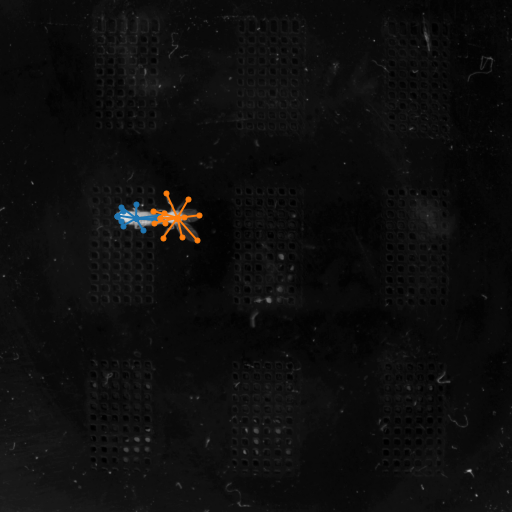

In [44]:
#labels[0].plot(scale=0.5)
!python -c "import sleap; import matplotlib.pyplot as plt; loaded_labels = sleap.load_file('my_predictions.slp'); loaded_labels[0].plot(scale=0.5); plt.savefig('my_plot.png')"

from IPython.display import Image
Image('my_plot.png')

The labeled frame is itself a container for instances:

In [45]:
#labeled_frame.instances

!python -c "import sleap; loaded_labels = sleap.load_file('my_predictions.slp'); print(loaded_labels[0].instances)"


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:10:19.176341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:10:19.176388: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

In [46]:
#instance = labeled_frame[0]  # shortcut for labeled_frame.instances[0]
#instance

!python -c "import sleap; loaded_labels = sleap.load_file('my_predictions.slp'); print(loaded_labels[0].instances[0])"

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:12:00.300994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:12:00.301035: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

Finally, instances are containers for points:

In [47]:
#instance.points
!python -c "import sleap; loaded_labels = sleap.load_file('my_predictions.slp'); print(loaded_labels[0].instances[0].points)"

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:12:30.011301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:12:30.011333: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

These can be converted into concrete arrays:

In [49]:
#pts = instance.numpy()
#print(pts)

!python -c "import sleap; loaded_labels = sleap.load_file('my_predictions.slp'); pts=loaded_labels[0].instances[0].numpy(); print(pts)"

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:14:06.062126: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:14:06.062167: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

Images can be embedded together with the predictions in the same format:

In [51]:
#labels = sleap.Labels(labels.labeled_frames[:4])  # crop to the first few labels for this example
#labels.save("labels_with_images.pkg.slp", with_images=True, embed_all_labeled=True)

#!python -c "import sleap; loaded_labels = sleap.load_file('my_predictions.slp'); print(loaded_labels)"
!python -c "import sleap; loaded_labels = sleap.load_file('my_predictions.slp'); labels = sleap.Labels(loaded_labels.labeled_frames[:4]); labels.save('labels_with_images.pkg.slp', with_images=True, embed_all_labeled=True)"

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:19:35.134553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:19:35.134597: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

Let's delete the source data:

In [52]:
!rm "190719_090330_wt_18159206_rig1.2@15000-17560.mp4"

And check out what happens when we load in some labels with embedded images:

In [53]:
#labels = sleap.load_file("labels_with_images.pkg.slp")
#labels

!python -c "import sleap; new_labels = sleap.load_file('labels_with_images.pkg.slp'); print(new_labels)"

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:21:05.125880: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:21:05.125916: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.
2025-04-20 20:22:55.180363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-04-20 20:22:55.180404: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To 

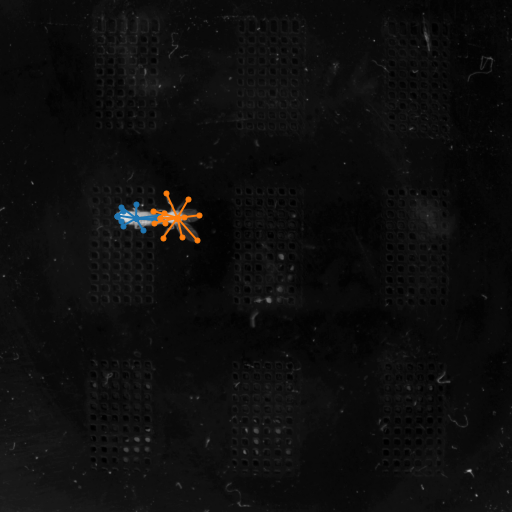

In [54]:
#labels[0].plot(scale=0.5)

!python -c "import sleap; import matplotlib.pyplot as plt; new_labels = sleap.load_file('labels_with_images.pkg.slp'); new_labels[0].plot(scale=0.5); plt.savefig('my_new_plot.png')"
from IPython.display import Image
Image('my_new_plot.png')